# Determinare se una prenotazione di hotel sarà cancellata o meno

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Federica Bedeschi  
`federica.bedeschi4@studio.unibo.it`

## Parte 1 - Obiettivo del modello e analisi del dataset

Si vuole realizzare un modello in grado di predire se una prenotazione di un hotel sarà cancellata o meno. Si tratta quindi di un problema di classificazione binaria.

In [1]:
# import librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Caricamento del dataset
*Fonte: Kaggle (https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)*

In [2]:
data = pd.read_csv("hotel_reservations.csv", index_col=0)

In [3]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Il dataset fa riferimento a una catena di hotel. Ogni riga rappresenta una prenotazione di una camera da parte di un cliente.

Come si può notare, l'indice (Booking_ID) è di fatto un numero progressivo, e non rispetta l'ordine cronologico delle date di prenotazione da parte dei clienti. Vedremo in seguito se questo sarà un problema per la divisione in training set e validation set ed eventualmente come risolverlo.

Le variabili presenti sono:
- no_of_adults: numero di adulti
- no_of_children: numero di bambini
- no_of_weekend_nights: numero di notti nel weekend (Sabato o Domenica) prenotate dal cliente
- no_of_week_nights: numero di notti infrasettimanali (da Lunedì a Venerdì) prenotate dal cliente
- type_of_meal_plan: tipo di piano dei pasti prenotato dal cliente ###### Type of meal plan booked by the customer
- required_car_parking_space: il cliente richiede il parcheggio auto? (0 - No, 1 - Sì)
- room_type_reserved: tipo di stanza prenotata dal cliente
- lead_time: numero di giorni tra la data di prenotazione e la data di arrivo in hotel
- arrival_year: anno della data di arrivo in hotel
- arrival_month: mese della data di arrivo in hotel
- arrival_date: giorno della data di arrivo in hotel
- market_segment_type: designazione del segmento di mercato (i.e. prenotazione effettuata online o offline)
- repeated_guest: il cliente è già stato ospite? (0 - No, 1 - Sì)
- no_of_previous_cancellations: numero di prenotazioni cancellate dal cliente prima della prenotazione corrente
- no_of_previous_bookings_not_canceled: numero di prenotazioni non cancellate dal cliente prima della prenotazione corrente
- avg_price_per_room: prezzo medio giornaliero della prenotazione (i prezzi delle camere sono dinamici)
- no_of_special_requests: numero di richieste speciali fatte dal cliente (ad esempio: piano alto, vista dalla camera, ecc)
- booking_status: indica se il cliente ha cancellato la prenotazione o meno (Canceled / Not_Canceled)

Quest'ultima è la variabile target da predire.

In [4]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_seg

Come si può notare dai conteggi, non sono presenti valori nulli, per cui non risulta necessario effettuare modifiche in tal senso.

Dividiamo ora le variabili in numeriche e categoriche, e mettiamo da parte quelle binarie:
- Variabili numeriche: no_of_adults, no_of_children, no_of_weekend_nights, no_of_week_nights, lead_time, arrival_year, arrival_month, arrival_date, no_of_previous_cancellations, no_of_previous_bookings_not_canceled, avg_price_per_room, no_of_special_requests
- Variabili categoriche: type_of_meal_plan, room_type_reserved
- Variabili binarie: required_car_parking_space, market_segment_type??????, repeated_guest

In [187]:
numeric_vars = ["no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights", "lead_time", "arrival_year",
                "arrival_month", "arrival_date", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled",
                "avg_price_per_room", "no_of_special_requests"]
categorical_vars = ["type_of_meal_plan", "room_type_reserved", "market_segment_type"]
binary_vars = ["required_car_parking_space", "repeated_guest"]

Le due variabili categoriche "type_of_meal_plan" e "room_type_reserved" sono memorizzate come object. Ricarichiamo quindi il dataframe specificando il tipo category per queste variabili.

In [6]:
data = pd.read_csv("hotel_reservations.csv",
                   index_col=0,
                   dtype={var: "category" for var in categorical_vars})

In [7]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          36275 non-null  int64   
 1   no_of_children                        36275 non-null  int64   
 2   no_of_weekend_nights                  36275 non-null  int64   
 3   no_of_week_nights                     36275 non-null  int64   
 4   type_of_meal_plan                     36275 non-null  category
 5   required_car_parking_space            36275 non-null  int64   
 6   room_type_reserved                    36275 non-null  category
 7   lead_time                             36275 non-null  int64   
 8   arrival_year                          36275 non-null  int64   
 9   arrival_month                         36275 non-null  int64   
 10  arrival_date                          36275 non-null  int64   
 1

Come si può notare, ora le due variabili categoriche sono classificate correttamente.

## Parte 2 - Analisi esplorativa del dataset

### Analisi delle singole feature

In [8]:
data.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


Così vediamo qualche dato utile, ma cerchiamo di esplorare più a fondo le variabili.
Iniziamo guardando la distribuzione della variabile target "booking_status".

In [9]:
data["booking_status"].value_counts()

Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

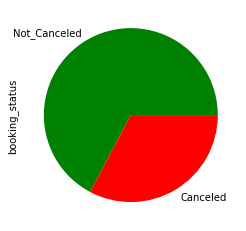

In [10]:
#booking_status_colors = {"Not_Canceled": "g", "Canceled": "r"}
data["booking_status"].value_counts().plot.pie(colors=["g", "r"]);#colors=booking_status_colors.values());

Si nota una distribuzione sbilanciata dei valori di booking_status. Occorrerà tenere conto di questo quando si modelleranno e valuteranno i modelli.

Andiamo ad analizzare meglio la distribuzione delle variabili utilizzando i grafici.

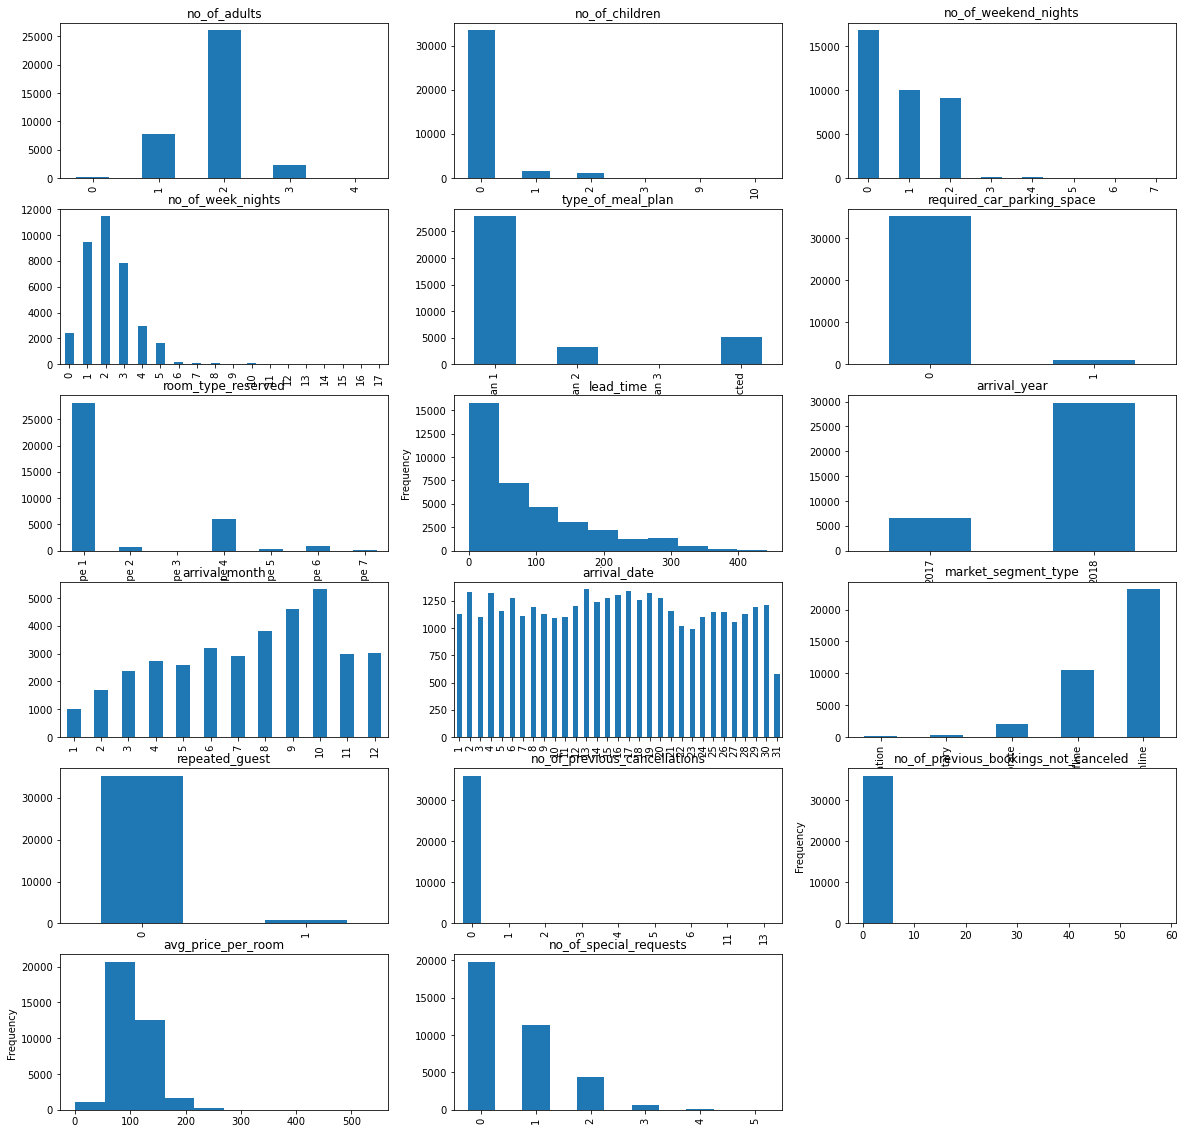

In [11]:
plt.figure(figsize=(20, 20))
for i, var in enumerate(data.columns.drop("booking_status"), start=1):
    if var in {"avg_price_per_room", "lead_time", "no_of_previous_bookings_not_canceled"}:
        data[var].plot.hist(ax=plt.subplot(6, 3, i), title=var)
    else:
        data[var].value_counts().sort_index().plot.bar(ax=plt.subplot(6, 3, i), title=var)

Notiamo ad esempio che la distribuzione di molte variabili è concentrata su un numero molto ristretto di valori.
In particolare, no_of_previous_cancellations, no_of_previous_bookings_not_canceled, required_car_parking_space, repeated_guest e, seppur meno, no_of_children, hanno valore 0 quasi nella totalità dei casi, facendo supporre una probabile trascurabile influenza di queste variabili.

Analizziamo più in dettaglio la variabile continua avg_price_per_room.

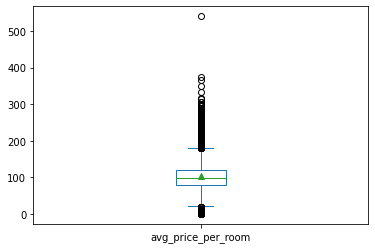

In [12]:
data["avg_price_per_room"].plot.box(showmeans=True);

Vediamo che ha una distribuzione normale, anche se con diversi outliers. PROBABILMENTE IL 500+ POTREBBE ESSERE ELIMINATO ???

Analizziamo ora la distribuzione di tutte le variabili evidenziando le due classi di predizione.

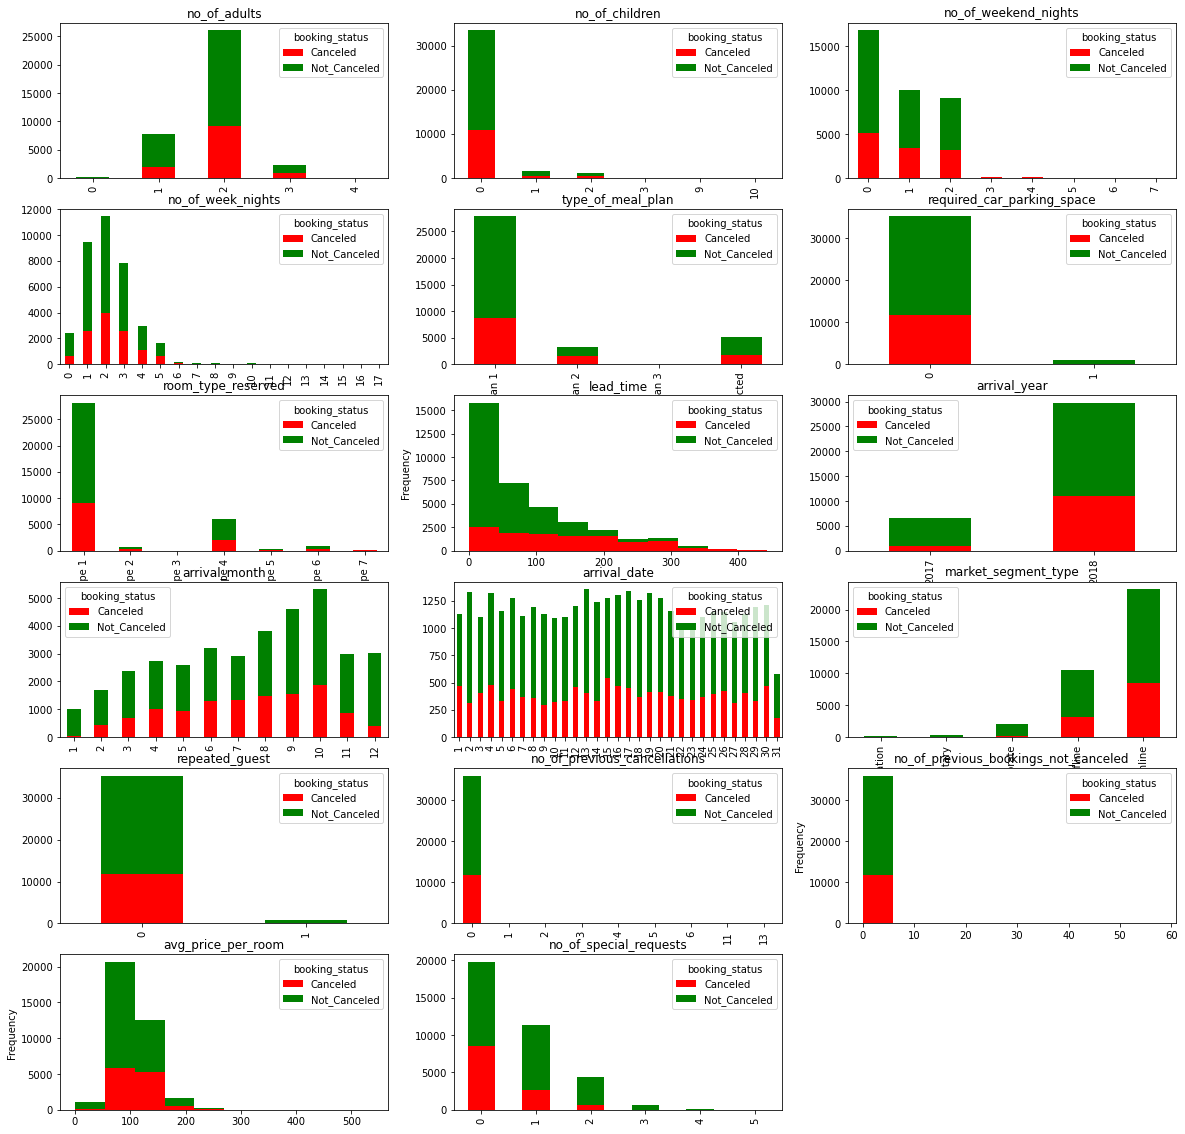

In [13]:
plt.figure(figsize=(20, 20))
for i, var in enumerate(data.columns.drop("booking_status"), start=1):
    if var in {"avg_price_per_room", "lead_time", "no_of_previous_bookings_not_canceled"}:
        data.pivot(columns="booking_status")[var].plot.hist(ax=plt.subplot(6, 3, i), title=var, stacked=True,
                                                            color=["r", "g"])
    else:
        data.groupby([var, "booking_status"]).size().unstack("booking_status").plot.bar(ax=plt.subplot(6, 3, i), title=var,
                                                                                stacked=True, color=["r", "g"], xlabel="")

Mentre per le altre variabili non si notano trend significativi, nei grafici della variabili lead_time e no_of_special_requests si possono notare due trend interessanti:
- all'aumentare del lead_time, la percentuale delle prenotazioni cancellate aumenta; questo sembra essere coerente con le aspettative, in quanto prenotando molto in anticipo è più probabile che ci siano imprevisti e si debba cancellare la prenotazione, rispetto al prenotare qualche giorno o qualche decina di giorni prima
- all'aumentare del no_of_special_requests, la percentuale delle prenotazioni cancellate diminuisce; anche questo sembra essere coerente con le aspettative, in quanto chiedere molte richieste speciali fa pensare a una prenotazione con più "impegno" rispetto ad una prenotazione con 0 (o poche) richieste, che fa pensare a una prenotazione "fatta di fretta" e magari con l'idea di cancellarla successivamente.

Si presuppone quindi un'importanza elevata delle variabili lead_time e no_of_special_requests.

### Cancellazione dati

In un'esplorazione successiva è stato notato che è presente come data il 29 febbraio 2018. Questo è sicuramente un errore nei dati in quanto tale data non esiste. Di conseguenza si procede eliminando le relative righe dal dataframe.

In [14]:
data = data.drop(data.loc[(data["arrival_year"] == 2018) & (data["arrival_month"] == 2) & (data["arrival_date"] == 29)].index)

### Analisi delle relazioni tra feature

Andiamo ora ad analizzare le relazioni tra le feature.

Visualizziamo le relazioni tra ogni coppia di feature attraverso i grafici a dispersione.

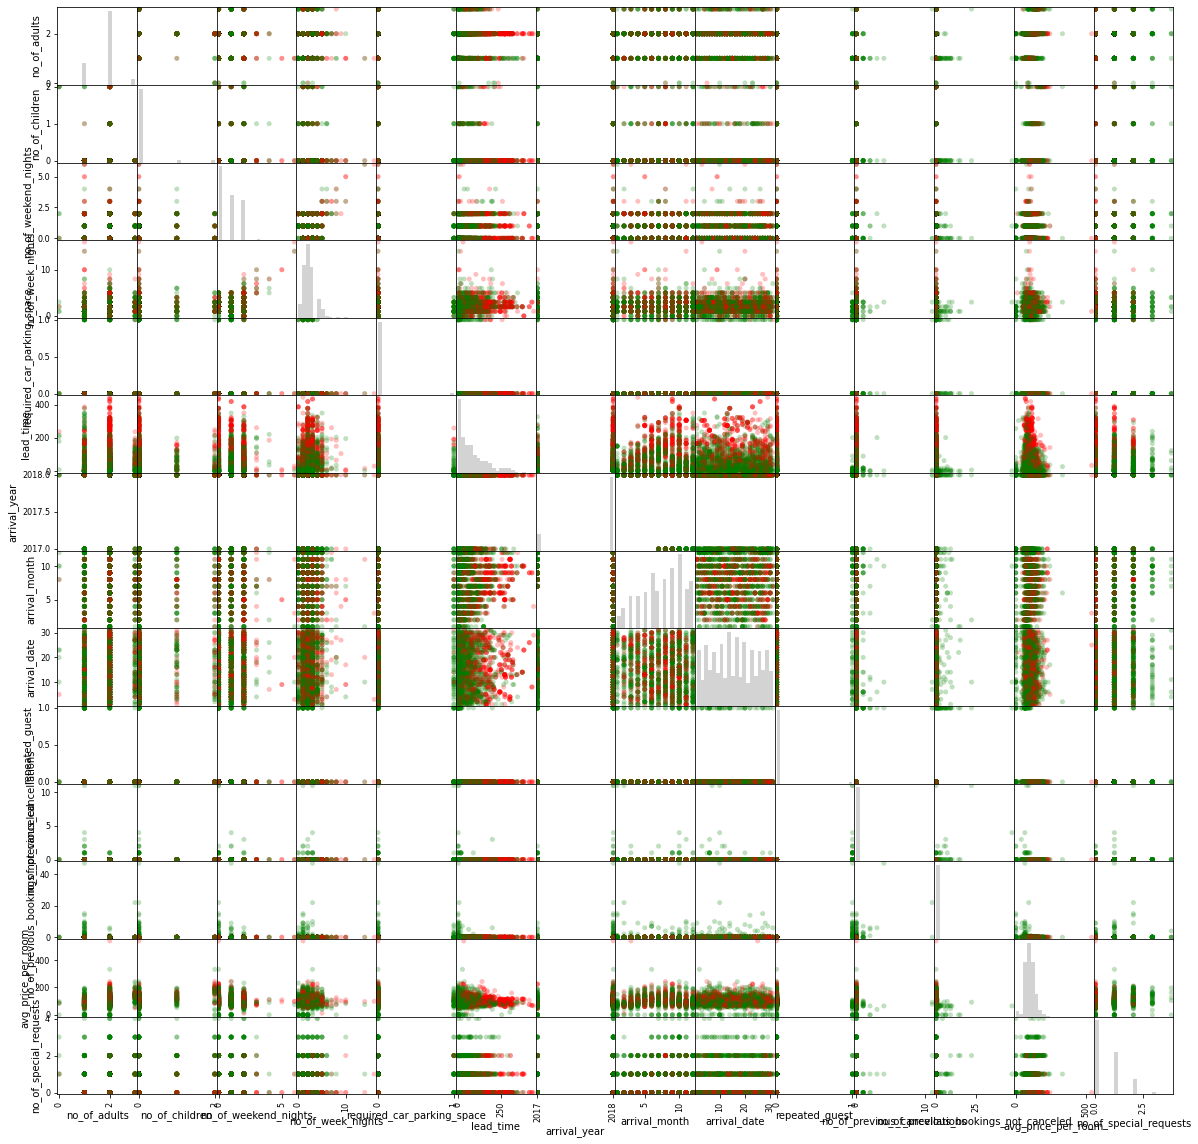

In [15]:
colors = {"Not_Canceled": "green", "Canceled": "red"}
sample = data.sample(2000)
_ = pd.plotting.scatter_matrix(#sample[["avg_price_per_room", "lead_time", "no_of_previous_bookings_not_canceled"]],
                               sample.drop(["booking_status"], axis=1), 
                               c=sample["booking_status"].map(colors),
                               alpha=0.25,
                               figsize=(20, 20), 
                               marker="o",
                               s=25,
                               hist_kwds={"bins": 20, "color": "lightgray"})

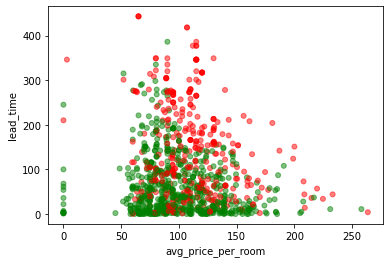

In [16]:
colors = {"Not_Canceled": "green", "Canceled": "red"}
sample = data.sample(1000)
sample.plot.scatter(
    "avg_price_per_room",                     # X
    "lead_time",                            # Y
    alpha=0.5,
    s=25,           # dimensione
    c=sample["booking_status"].map(colors)   # colore
);

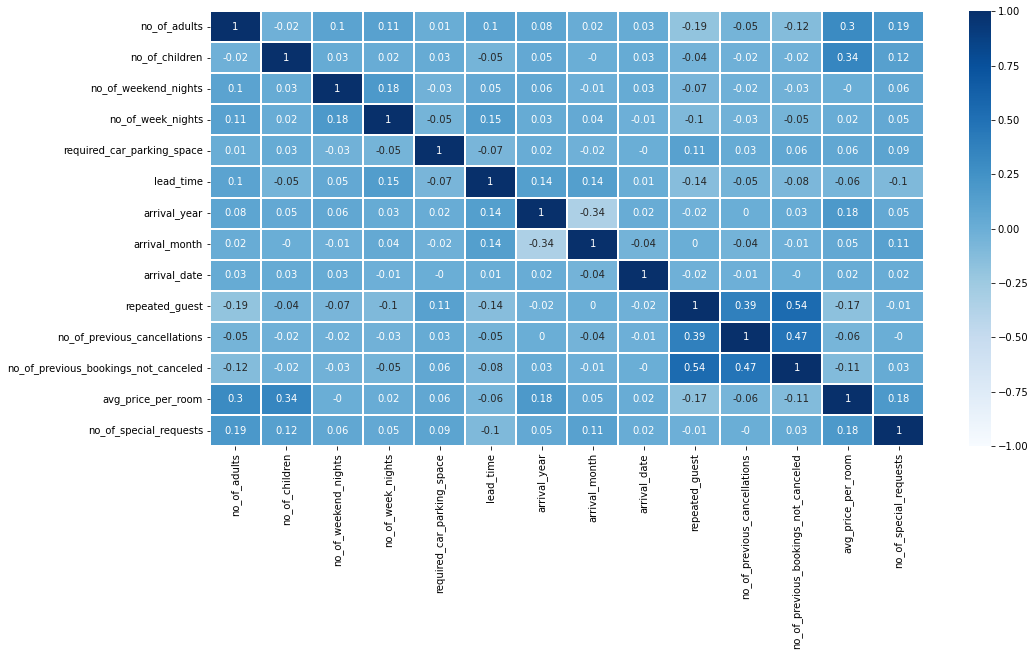

In [17]:
import seaborn as sns
plt.figure(figsize=(16,8))
#plt.tight_layout(pad=2.0)
corr_matrix = data.corr().round(2)
sns.heatmap(corr_matrix, annot=True, cmap="Blues", linewidths=0.2, fmt=".2g", vmin=-1, vmax=1)
#plt.title("Pearson Correlation Heatmap")
plt.show()

Notiamo che non ci sono correlazioni rilevanti. Sono presenti alcune correlazioni elevate come 0.54 o 0.39 ma sono dovute alla distribuzione dei dati, per tanto risultano irrilevanti.

## Parte 3 - Preparazione dei dati per l'addestramento e la validazione dei modelli di predizione

Come menzionato prima, il dataframe non è ordinato.

L'obiettivo è ora di renderlo ordinato in base alla data di prenotazione, così da poter dividere i dati in training set e test set in ordine temporale, rendendolo realistico. Per fare ciò, si crea una colonna date che rappresenta la data di arrivo formata da anno, mese e giorno presi dalle colonne arrival_year, arrival_month e arrival_date, a cui si sottrae il lead_time, ottenendo così le date di prenotazione. Si imposta quindi la colonna date come indice del dataframe e si ordina in ordine crescente.

In [23]:
pd.to_datetime(data["arrival_year"].astype(str) + "-" +
               data["arrival_month"].astype(str) + "-" +
               data["arrival_date"].astype(str),
               format="%Y-%m-%d")
data["booking_date"] = pd.to_datetime(data["arrival_year"].astype(str) + "-" +
               data["arrival_month"].astype(str) + "-" +
               data["arrival_date"].astype(str),
               format="%Y-%m-%d")
data["booking_date"] = data["booking_date"] - pd.to_timedelta(data["lead_time"], unit='d')
data = data.set_index("booking_date")
data = data.sort_index()

In [49]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
booking_date,,,,,,,,,,,,,,,,,,
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,273,2017,7,17,Online,0,0,0,109.0,0,Canceled
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,257,2017,7,1,Offline,0,0,0,101.5,0,Canceled
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,273,2017,7,17,Online,0,0,0,109.0,0,Canceled
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,257,2017,7,1,Online,0,0,0,101.5,0,Canceled
2016-10-17,1,0,0,2,Meal Plan 2,0,Room_Type 1,257,2017,7,1,Offline,0,0,0,80.0,0,Not_Canceled


In [25]:
data.index.value_counts() # DA TOGLIERE

2017-10-02    644
2017-07-06    438
2018-01-03    413
2018-04-04    303
2018-01-06    282
             ... 
2017-02-25      1
2017-02-24      1
2017-02-16      1
2017-02-11      1
2018-12-30      1
Name: booking_date, Length: 635, dtype: int64

A questo punto, si può procedere con le divisioni.

### Divisione delle variabili tra predittive e target

booking_status è la variabile target da predire, dividiamo quindi il dataset come segue.

In [51]:
X = data.drop(columns="booking_status")
y = data["booking_status"]

### Divisione in training set e test set

Dividiamo ora il dataset in training set e test set, prendendo le prime n righe per il training set e le rimanenti per il test set. Viene definita una funzione che si occupa di questo, alla quale occorre passare il parametro per decidere la dimensione del training set.

In [79]:
def split_dataset(X, y, train_size):
    if train_size <= 0 or train_size >= 1:
        raise Exception("Invalid test size")
    pivot = round(len(X) * train_size)
    X_train = X.iloc[:pivot]
    y_train = y.iloc[:pivot]
    X_val = X.iloc[pivot:]
    y_val = y.iloc[pivot:]
    return X_train, y_train, X_val, y_val

In [80]:
X_train, y_train, X_val, y_val = split_dataset(X, y, train_size=0.7)

### Preprocessing

Per usare le variabili categoriche in un modello di predizione, occorre trasformarle in numeriche. Per fare questo utilizziamo il **one-hot encoding**, che converte ogni variabile categorica in n variabili numeriche binarie.

Prepariamo quindi un transformer che:
- per le variabili numeriche, lascia la possibilità di pre-processare in modi diversi successivamente;
- per le variabili categoriche, effettua il one-hot encoding;
- per le variabili binarie, non effettua alcun tipo di pre-processing in quanto non necessario.

In [189]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # usato successivamente

transformer = ColumnTransformer([
    ("numeric",     ...,             numeric_vars),           # StandardScaler()
    ("categorical", OneHotEncoder(), categorical_vars),
    ("binary",      "passthrough",   binary_vars)
])

## Parte 3 - Addestramento e valutazione di modelli

Saranno utilizzati i seguenti modelli di classificazione: Perceptron, Logistic Regression e Decision Tree. Ogni modello sarà addestrato utilizzando la Grid Search e validato usando la Nested k-fold cross validation.
Si prepara quindi il codice necessario ad addestrare e valutare ogni modello.

Si comincia col preparare la tupla del pre-processing da inserire nella pipeline di ogni modello e la grid del pre-processing.

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

preproc_tuple = ("preproc", transformer)
preproc_grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__categorical__drop": [None, "first"]
}

In [112]:
# DA TOGLIERE PARTE COMMENTATA ROSSAAAAAAA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# StratifiedKFold è una variante di KFold che garantisce uguale distribuzione delle classi tra un fold e l'altro, cosa
# che risulta fondamentale trattandosi di una classificazione
"""
skf = StratifiedKFold(3, shuffle=True, random_state=42)

gs = GridSearchCV(model, grid, cv=skf)

#from sklearn.model_selection import cross_validate
#cv_result = cross_validate(model, X, y, cv=kf, return_train_score=True)

# nested cross validation
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        results.append(gs.score(X_val, y_val))
    return results
"""
# nested cross validation
outer_cv = StratifiedKFold(3, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(5, shuffle=True, random_state=42)
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        results.append(gs.score(X_val, y_val))
        
        print(gs.best_params_)
        print(pd.DataFrame(gs.cv_results_).sort_values("rank_test_score"))
    return results

In [ ]:
"""kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(data_train, y_train);"""

In [ ]:
#gs.best_params_
#pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

Prepariamo le liste.

In [172]:
tuples = []
grids = []

### Perceptron

In [173]:
from sklearn.linear_model import Perceptron

perceptron_tuple = ("perc", Perceptron(n_jobs=-1, random_state=42)) # n_jobs=-1 -> usa tutti i processori
perceptron_grid = {
    "perc__penalty": ["l2", "l1", "elasticnet"],
    "perc__alpha": np.logspace(-2, 2, 5),
    "perc__fit_intercept": [False, True]
}

tuples.append(perceptron_tuple)
grids.append(perceptron_grid)

### Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression

lr_tuple = ("lr", LogisticRegression(solver='saga', random_state=42))
lr_grid = {
    #"lr__fit_intercept": [False, True]   # ??????????????????????????????????????????????
    #{
    #    "penalty": ["l2", "l1"],
    #    "C": [0.1, 1, 10]
    #},
    #{
    #    "penalty": ["elasticnet"],
    #    "C": [0.1, 1, 10],
    #    "l1_ratio": [0.2, 0.5]
    #} 
    "lr___penalty": ["l2", "l1", "elasticnet"],
    "lr___C": [0.1, 1, 10],
    "lr___l1_ratio": [0.2, 0.5]
}

tuples.append(lr_tuple)
grids.append(lr_grid)

### Decision Tree

In [175]:
from sklearn.tree import DecisionTreeClassifier

tree_tuple = ("tree", DecisionTreeClassifier())
tree_grid = {
    "tree__min_samples_split": [2, 3, 4],
    "tree__min_samples_leaf": [2, 3, 4], 
    "tree__max_depth": [None, 3, 4]
}

tuples.append(tree_tuple)
grids.append(tree_grid)

Aggiorniamo models e grids.

In [ ]:
models = [Pipeline([preproc_tuple, t]) for t in tuples]
grids = [dict(preproc_grid, **g) for g in grids]

Addestriamo e valutiamo tutti i modelli definiti.

In [178]:
for i in range(len(models)):
    results = nested_cv(models[i], grids[i])
    print(results)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [191]:
perc_model = Pipeline([
    ("preproc", transformer),
    ("perc", Perceptron(n_jobs=-1, random_state=42))
])
perc_grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__categorical__drop": [None, "first"],
    "perc__penalty": ["l2", "l1", "elasticnet"],
    "perc__alpha": np.logspace(-2, 2, 5),
    "perc__fit_intercept": [False, True]
}
results = nested_cv(perc_model, perc_grid)
print(results)

{'perc__alpha': 0.01, 'perc__fit_intercept': True, 'perc__penalty': 'l1', 'preproc__categorical__drop': 'first', 'preproc__numeric': StandardScaler()}
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19        0.132495      0.027512         0.022951        0.002043   
17        0.112491      0.025781         0.021707        0.002119   
23        0.107891      0.013156         0.021319        0.003218   
9         0.123134      0.019513         0.020874        0.001524   
18        0.114810      0.017007         0.021622        0.003139   
..             ...           ...              ...             ...   
83        0.118059      0.010197         0.027910        0.001058   
55        0.118766      0.027892         0.025503        0.007386   
53        0.102334      0.010410         0.021765        0.003731   
103       0.120631      0.003513         0.026362        0.002298   
106       0.136175      0.023323         0.021854        0.001820   

    param_perc__alph

KeyboardInterrupt: 

In [190]:
# definizione con transformer definito a parte
transformer = ColumnTransformer([
    ("numeric"    , StandardScaler(), numeric_vars + binary_vars),
    ("categorical", OneHotEncoder() , categorical_vars)
])
model = Pipeline([
    ("preproc", transformer),
    ("regr"   , Perceptron())
])

# definizione equivalente con transformer innestato
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_vars + binary_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("regr", Perceptron())
])

model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7635912059608132